In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
 
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

In [2]:
df = pd.read_csv('datas/ETTm1.csv')
df.head(2)

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,7/1/2016 0:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,7/1/2016 0:15,5.760,2.076,1.492,0.426,4.264,1.401,30.459999


In [3]:
# 初始化标准化器
scaler = StandardScaler()
cols_data = df.columns[1:]
df_data = df[cols_data]
scaler.fit(df_data.values)
data_scaled = scaler.transform(df_data.values)

In [4]:
# 将时间列转换为 DataFrame
df_time = pd.DataFrame(df['date'])  # 假设时间列名为'date'
df_scaled_with_time = pd.concat([df_time, pd.DataFrame(data_scaled, columns=cols_data)], axis=1)

In [12]:
l = int(len(df)*0.2)
train = df_scaled_with_time[:-l]
test = df_scaled_with_time[-l:]
len(test)

13801

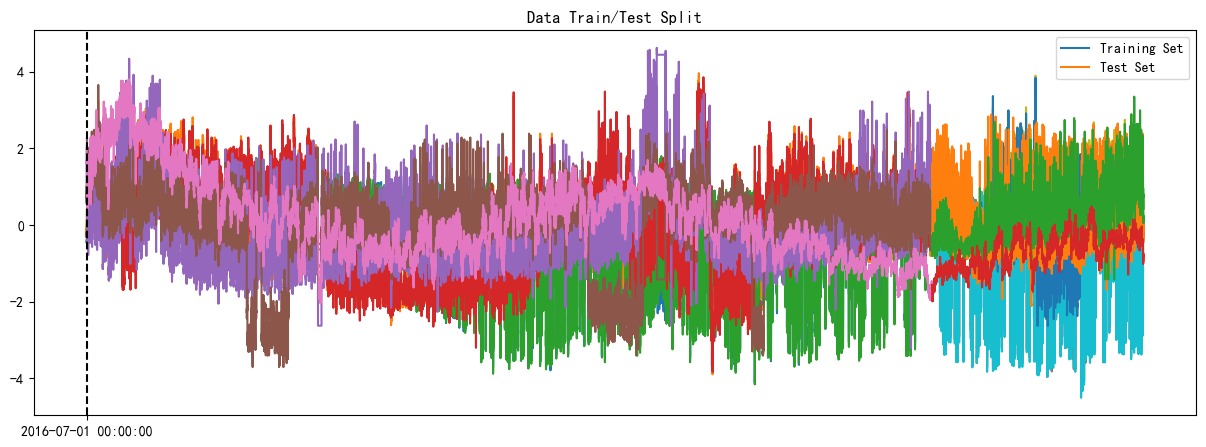

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2016-07-01 00:00:00', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [14]:
FEATURES = ['HUFL','HULL','MUFL','MULL','LUFL','LULL']
TARGET = 'OT'
 
X_train = train[FEATURES]
y_train = train[TARGET]
 
X_test = test[FEATURES]
y_test = test[TARGET]

In [15]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:1.07517	validation_1-rmse:1.26430


c:\Users\BeiFeng\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:00:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.93667	validation_1-rmse:1.10037
[200]	validation_0-rmse:0.88799	validation_1-rmse:1.02207
[300]	validation_0-rmse:0.86570	validation_1-rmse:0.98574
[400]	validation_0-rmse:0.85292	validation_1-rmse:0.96971
[500]	validation_0-rmse:0.84448	validation_1-rmse:0.95898
[600]	validation_0-rmse:0.83776	validation_1-rmse:0.95471
[700]	validation_0-rmse:0.83263	validation_1-rmse:0.94467
[800]	validation_0-rmse:0.82859	validation_1-rmse:0.93918
[900]	validation_0-rmse:0.82475	validation_1-rmse:0.93410
[999]	validation_0-rmse:0.82203	validation_1-rmse:0.93146


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

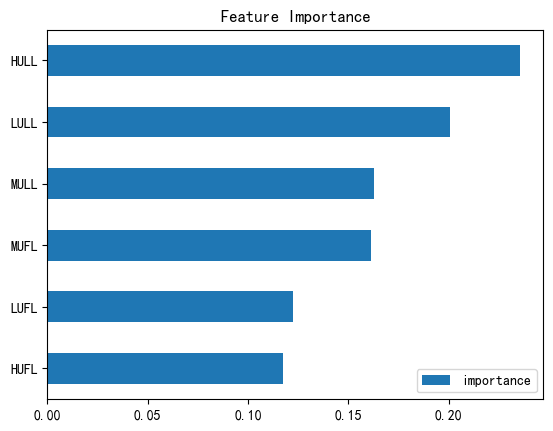

In [16]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=FEATURES,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

C:\Users\BeiFeng\AppData\Local\Temp\ipykernel_5064\932785016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


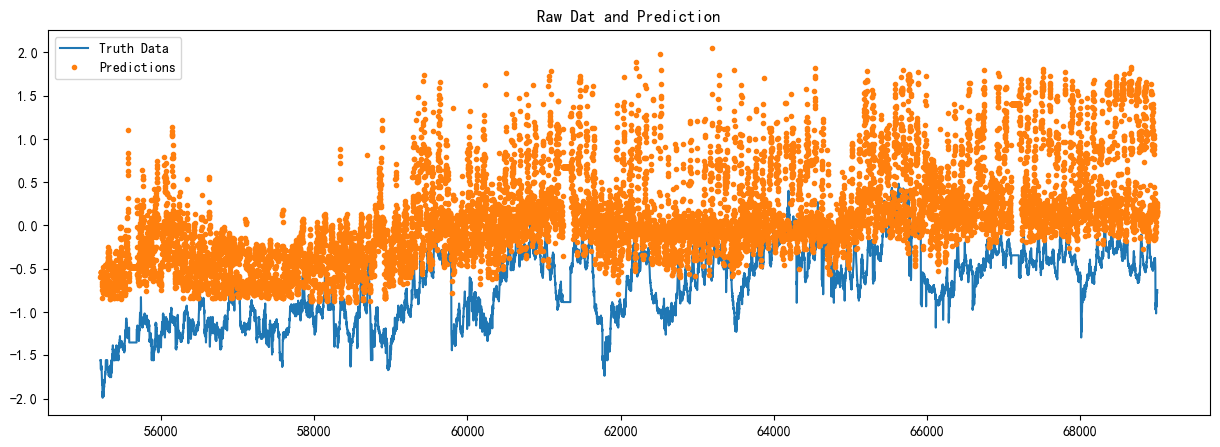

In [17]:
test['prediction'] = reg.predict(X_test)
ax = test[['OT']].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

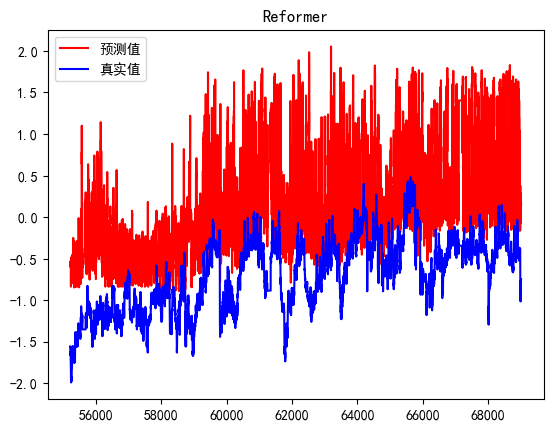

In [18]:
plt.rcParams['font.sans-serif'] = ['Kaitt', 'SimHei']
plt.figure()
plt.plot(test['prediction'],color='red', label='预测值')
plt.plot(test['OT'],color='blue', label='真实值')
plt.title('Reformer')
plt.legend()
plt.rcParams['axes.unicode_minus'] = False
plt.show()

In [19]:
from metrics import metric
# 计算MSE和MAE
mae, mse, rmse, mape, mspe = metric(test['prediction'], test['OT'])
# test_mse = mean_squared_error(test_result['y'], test_result['yhat'])
# test_mae = mean_absolute_error(test_result['y'], test_result['yhat'])

print(f"验证集 MSE: {mse}, MAE: {mae}")
# print(f"测试集 MSE: {test_mse}, MAE: {test_mae}")

验证集 MSE: 0.8675534996088289, MAE: 0.7912275476480101
